# An introduction into Regional Feature Effects

This tutorial is a gentle introduction to Regional feature effects and the `Effector` package. Regional feature effects bridge the gap between local and global feature effects. The [REPID](https://proceedings.mlr.press/v151/herbinger22a/herbinger22a.pdf) method was recently introduced to find regions within the feature space which minimizes feature interactions (interaction-related heterogeneity) based on ICE curves and PDPs for one feature of interest. This approach was extended to ALE and SHAP Dependence Plots for multiple features of interest by [GADGET](https://arxiv.org/pdf/2306.00541.pdf) (with REPID being a special case of GADGET). Here, we illustrate the advantages of GADGET-PD and GADGET-ALE (RHALE) compared to their global alternatives in the presence of feature interactions. We also illustrate the advantage of GADGET-ALE compared to GADGET-PD in the presence of high correlations in the feature space.
GADGET-PD and GADGET-ALE are both provided in the `Effector` package. We showcase its userfriendly applicability in the following simulation example.

The tutorial is structured as follows:
 - Introduction of the simulation example: We consider a simple linear setting with subgroup-specific feature interactions, which will be defined with independent features and with dependent features.
 - Modeling: We fit a neural network on the two data sets (uncorrelated vs. correlated)
 - PDP - Influence of feature interactions and feature correlations
 - RHALE - Influence of feature interactions and feature correlations
 - Regional Effects: GADGET-PD and GADGET-ALE
 


In [13]:
import numpy as np
import effector
from sklearn.neural_network import MLPRegressor as mlp

---
## Introduction of the simulation example

We will generate $N=500$ examples with $D=3$ features, which are in the uncorrelated setting all uniformly distributed as follows:

<center>

| Feature | Description | Distribution |
| --- | --- | --- |
| $x_1$ | Uniformly distributed between $-1$ and $1$ | $x_1 \sim \mathcal{U}(0,1)$ |
| $x_2$ | Uniformly distributed between $-1$ and $1$ | $x_2 \sim \mathcal{U}(0,1)$ |
| $x_3$ | Uniformly distributed between $-1$ and $1$ | $x_3 \sim \mathcal{U}(0,1)$ |

</center>
For the correlated setting we keep the distributional assumptions for $x_2$ and $x_3$ but define $x_1$ such that it is highly correlated with $x_3$ by: $x_1 = x_3 + \delta$ with $\delta \sim \mathcal{N}(0,0.0625)$.

In [66]:
def generate_dataset_uncorrelated(N):
    x1 = np.random.uniform(-1, 1, size=N)
    x2 = np.random.uniform(-1, 1, size=N)
    x3 = np.random.uniform(-1, 1, size=N)
    return np.stack((x1, x2, x3), axis=-1)

def generate_dataset_correlated(N):
    x3 = np.random.uniform(-1, 1, size=N)
    x2 = np.random.uniform(-1, 1, size=N)
    x1 = x3 + np.random.normal(loc = np.zeros_like(x3), scale = 0.25)
    return np.stack((x1, x2, x3), axis=-1)

# generate the dataset for the uncorrelated and correlated setting
np.random.seed(123)
N = 500
X_uncor = X_uncor_train = generate_dataset_uncorrelated(N)
X_uncor_test = generate_dataset_uncorrelated(10000)
X_cor = X_cor_train = generate_dataset_correlated(N)
X_cor_test = generate_dataset_correlated(10000)


---
## Modeling

We will use the following linear model with a subgroup-specific interaction term, $y = 3x_1I_{x_3>0} - 3x_1I_{x_3\leq0} + x_3 + \epsilon$ with $\epsilon \sim \mathcal{N}(0, 0.09)$. On a global level, there is a high heterogeneity for the features $x_1$ and $x_3$ due to their interaction with each other. However, this heterogeneity vanishes to 0 if the feature space is separated into two regions with respect to $x_3 = 0$. In this case only main effects remain in the two regions: 

<center>

| Feature |Region | Average Effect | Heterogeneity |
| --- | --- | --- |--- |
| $x_1$ | $x_3>0$| $3x_1$ | 0 |
| $x_1$ | $x_3\leq 0$| $-3x_1$ | 0 |
| $x_3$ | $x_3>0$| $x_3$ | 0 |
| $x_3$ | $x_3\leq 0$| $x_3$ | 0 |

</center>

Since $x_2$ does not have any influence (neither main nor interaction effect) on the target, the average effect and the heterogeneity of this feature are $0$ (globally and regionally).
Note that the average effect of $x_1$ cancels out on a global level and thus only considering the average global effect would suggest no influence of the feature on the target.

In [67]:
def generate_target(X):
    f = np.where(X[:,2] > 0, 3*X[:,0] + X[:,2], -3*X[:,0] + X[:,2])
    epsilon = np.random.normal(loc = np.zeros_like(X[:,0]), scale = 0.3)
    Y = f + epsilon
    return(Y)

# generate target for uncorrelated and correlated setting
np.random.seed(123)
Y_uncor_train = generate_target(X_uncor_train)
Y_uncor_test = generate_target(X_uncor_test)
Y_cor_train = generate_target(X_cor_train)
Y_cor_test = generate_target(X_cor_test)      

#### Fit a Neural Network

We train a single-layer feedforward Neural Network of size 10, a weight decay of 0.001 and a maximum number of iterations of 1000 (HPO was done by Herbinger et. al (2023) for this example) on the uncorrelated and the correlated setting.

In [75]:
# Train - Evaluate - Explain a neural network
np.random.seed(123)

# Train and evaluate model for uncorrelated setting
model_uncor = mlp(hidden_layer_sizes=(10,), alpha=0.001, max_iter=1000)
model_uncor.fit(X_uncor_train, Y_uncor_train)
print('Train error:', model_uncor.score(X_uncor_train, Y_uncor_train),
'Test error:', model_uncor.score(X_uncor_test, Y_uncor_test)
)

# Train and evaluate model for correlated setting
model_cor = mlp(hidden_layer_sizes=(10,), alpha=0.001, max_iter=1000)
model_cor.fit(X_cor_train, Y_cor_train)
print('R-squared train:', model_cor.score(X_cor_train, Y_cor_train),
'R-squared test:', model_cor.score(X_cor_test, Y_cor_test)
)

c:\users\ra98jit\pycharmprojects\effector\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Train error: 0.9111117922353494 Test error: 0.902033797076519
R-squared train: 0.9171093609098825 R-squared test: 0.9014223443399886


---
## PDP - Influence of feature interactions and feature correlations



Let' s estimate some notation for the rest of the tutorial:

<center>

| Symbol                                                     | Description                                             |
|------------------------------------------------------------|---------------------------------------------------------|
| $f(\mathbf{x})$                                            | The black box model                                     |
| $x_s$                                                      | The feature of interest                                 |
| $x_c$                                                      | The remaining features, i.e., $\mathbf{x} = (x_s, x_c)$ |
| $\mathbf{x} = (x_s, x_c) = (x_1, x_2, ..., x_s, ..., x_D)$ | The input features                                      |
| $\mathbf{x}^{(i)} = (x_s^{(i)}, x_c^{(i)})$                | The $i$-th instance of the dataset                      |

The PDP is defined as **_the average of the model's prediction over the entire dataset, while varying the feature of interest._**
PDP is defined as 

$$ \text{PDP}(x_s) = \mathbb{E}_{x_c}[f(x_s, x_c)] $$ 

and is approximated by 

$$ \hat{\text{PDP}}(x_s) = \frac{1}{N} \sum_{j=1}^N f(x_s, x^{(i)}_c) $$

Therfore, the PDP is an verage over the underlying ICE curves (local effects) which visualize how the feature of interest influences the prediction of the ML model for each single instance. Heterogeneous ICE curves indicate feature interactions. Therefore, we are expecting heterogeneous ICE curves for $x_1$ and $x_3$ for our uncorrelated simulation example, which can be explained by the underlying feature interactions.

Let's check it out the PDP effect using `effector`.

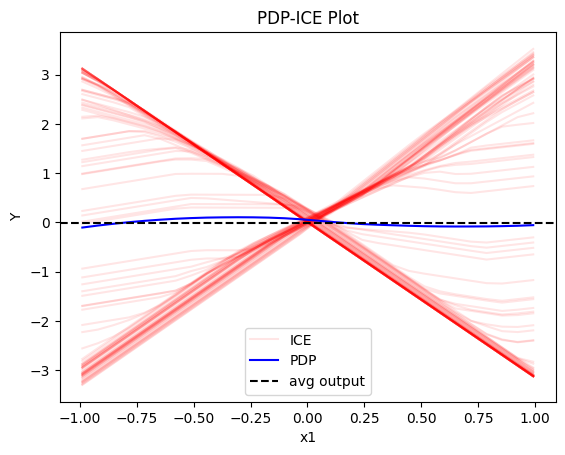

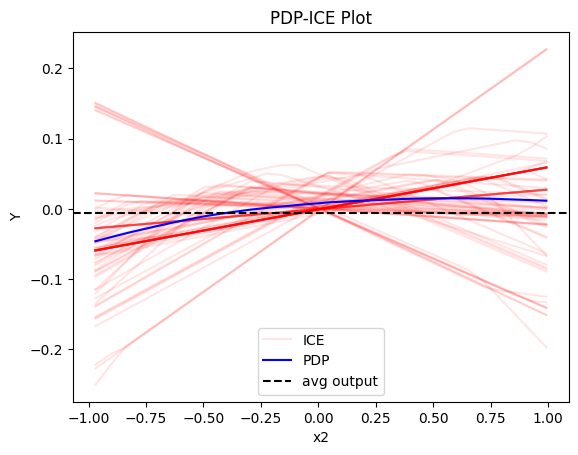

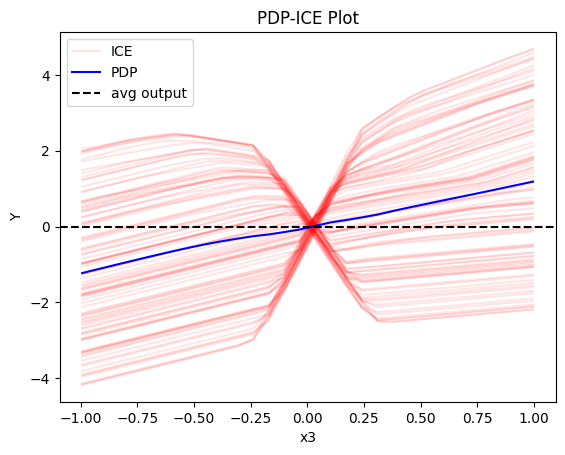

In [69]:
pdp = effector.PDP(data=X_uncor_train, model=model_uncor.predict, feature_names=['x1','x2','x3'], target_name="Y")
fig, ax = pdp.plot(feature=0, centering=True, show_avg_output=True, confidence_interval="ice")
fig, ax = pdp.plot(feature=1, centering=True, show_avg_output=True, confidence_interval="ice")
fig, ax = pdp.plot(feature=2, centering=True, show_avg_output=True, confidence_interval="ice")

In the uncorrelated setting $x_1$ has - as expected - an average global feature effect of $0$ while the heteroeneous ICE curves indicate the underlying feature interactions with $x_3$. Also $x_3$ demonstrates a high heterogeneity of local effects while the average global effect represents the underlying main effect of $x_3$. $x_2$ varies as expected around $0$ with small heterogeneity (note the difference in the scale of the y-axis).

Since the PDP assumes feature independence, we can observe in the highly correlated setting the following artifact: $x_1$ and $x_3$ are highly positively correlated, therefore, the combination of small (high) $x_1$ and high (small) $x_3$ feature values is not avaiable and thus has not been seen by the model during the training process. However, ICE curves and PDPs are visualized for the entire feature range of the feature of interest (e.g., $x_1$). Thus, we extrapolate with our model (here NN) into unseen or sparse regions of the feature space. This might lead to an osciliating behavior depending on the underlying chosen ML model. Therefore, we might receive heterogeneity of local effects (ICE curves) which are not caused by feature interactions but by extrapolation due to feature correlations. This behavior is especially visible for feature $x_1$ in our example.   

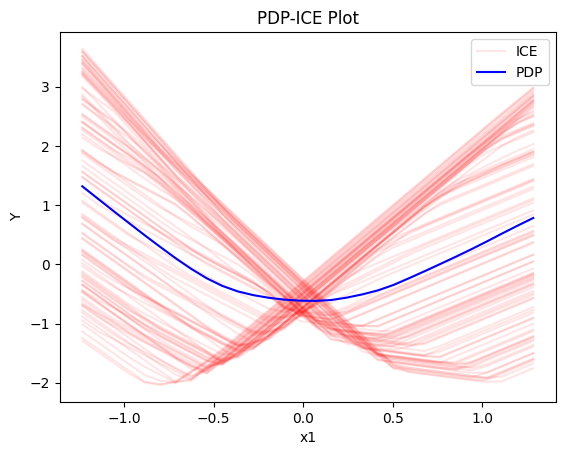

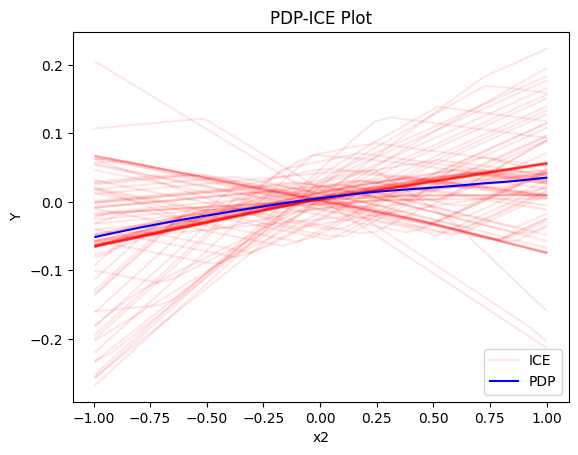

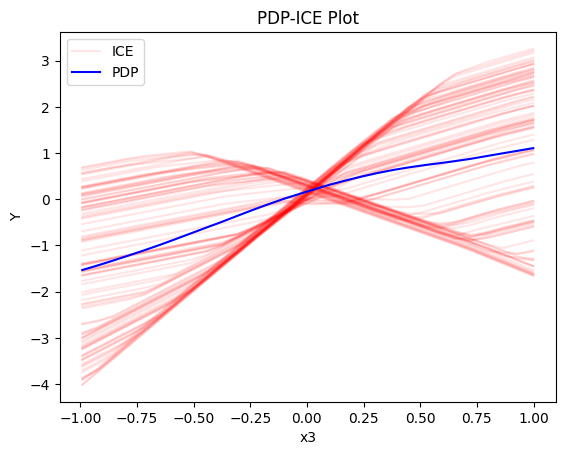

In [71]:
pdp = effector.PDP(data=X_cor_train, model=model_cor.predict, feature_names=['x1','x2','x3'], target_name="Y")
fig, ax = pdp.plot(feature=0, centering=True, show_avg_output=False, confidence_interval="ice")
fig, ax = pdp.plot(feature=1, centering=True, show_avg_output=False, confidence_interval="ice")
fig, ax = pdp.plot(feature=2, centering=True, show_avg_output=False, confidence_interval="ice")

## RHALE

# Regional Effects

GADGET creates interpretable and distinct regions within the feature space such that the interaction-related heterogeneity is minimized within the regions. Thus, we aim to receive main effects of the features within the regions. 

### GADGET-PD

In the case of PDPs and ICE this means, that we minimize the heterogeneity of mean-centered ICE curves. This means that we group ICE curves with a similar shape, i.e., we find regions in which the instances within this regions show a similar influence on the prediction for the feature of interests, while this influence differs for other regions.

In [79]:
regional_pdp = effector.RegionalPDP(
    data=X_train,
    model=predict,
    cat_limit=10,
    feature_names=['x1','x2','x3'],
)

regional_pdp.fit(
    features=0,
    heter_small_enough=0.1,
    heter_pcg_drop_thres=0.1,
    max_split_levels=2,
    nof_candidate_splits_for_numerical=5,
    min_points_per_subregion=10,
    candidate_conditioning_features="all",
    split_categorical_features=True,
)

100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.65it/s]


In [85]:
regional_pdp.describe_subregions(features=0, only_important=True)

Important splits for feature x1
- On feature x3 (cont)
  - Range: [-0.99, 1.00]
  - Candidate split positions: -0.79, -0.40, 0.00, 0.40, 0.80
  - Position of split: 0.00
  - Heterogeneity before split: 0.53
  - Heterogeneity after split: 0.29
  - Heterogeneity drop: 0.24 (82.96 %)
  - Number of instances before split: 500
  - Number of instances after split: [250, 250]
